In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Results:
    def __init__(self, measure, dataset_name, model_name, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.specific_train_route = specific_train_route
        self.x = x
        self.measure = measure
        self.relative_path = f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv'
        self.data = self.data_from_files(self.relative_path, self.measure)
        #if measure == 'Error':
        #    self.data = self.data_from_files_error(self.relative_path, self.measure)
        self.data_route = self.extract_train_routes(specific_train_route, self.data)
    
    def data_from_files(self, relative_path, measure):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(self.x):
                if measure == 'Error':
                    file_dict[f'{measure}_baseline{i}'] = data_from_file[f'{measure}_baseline{i}'][0]
                    file_dict[f'{measure}_ARIMA{i}'] = data_from_file.get(f'{measure}_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = data_from_file[f'{measure}_full{i}'][0]
                else:
                    file_dict[f'{measure}_baseline{i}'] = [data_from_file[f'{measure}_baseline{i}']]
                    file_dict[f'{measure}_ARIMA{i}'] = [data_from_file.get(f'{measure}_ARIMA{i}', [None])] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = [data_from_file[f'{measure}_full{i}']]
                    if measure == 'Predictions':
                        file_dict[f'y_true{i}'] = [data_from_file[f'y_true{i}']]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
        return result_df
    
    def extract_train_routes(self, specific_train_route, data):
        return data[data['route_station'].str.startswith(f'({specific_train_route},')]
    
    def plot_function():
        print('Not implemented...')
    def plot_caller():
        print('Not implemented')
    

In [41]:
from scipy.stats import wilcoxon
class Errors(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Error', dataset_name, model_names, specific_train_route, x)
        
    def error_plot_across_days(self, df):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline0'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(num_predictions):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('Error')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        plt.show()

    def error_plot(self, df):
        df = df.sort_values(by='route_station')

        bar_width = 0.25
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline0'], bar_width, label='Baseline')
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA0' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA0'], bar_width, label='ARIMA')
            displacement = 2
        # Plot full errors
        plt.bar([i + displacement*bar_width for i in index], df['Error_full0'], bar_width, label='Full')

        plt.xlabel('(Route, Station)')
        plt.ylabel('Error')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.data.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors)
            else:
                self.error_plot_across_days(mean_errors)
        else:
            self.error_plot(self.data_route)

    def median_histogram(self, i=0):
        columns = np.unique([col.split('_')[-1][:-1] for col in self.data.columns if col.startswith('Error')])
        for column_name in columns:
            result_data = self.data[f'Error_{column_name}{str(i)}'] # np.sqrt(result[cv])
            plt.hist(result_data)
            plt.axvline(np.median(result_data), color='red', linestyle='dashed', linewidth=1, label='Median')
            plt.title(f'Error for model={column_name} and i={i}')
            plt.xlabel('MAE')
            plt.ylabel('Occurences')
            plt.legend()
            plt.show()
    
    def wilcoxon_test(self, specific_model='', i=0, alpha=0.05):
        model_columns = [col.split('_')[-1] for col in self.data.columns if col.endswith(str(i))]
        if specific_model:
            print(f'Specific model Comparison: {specific_model}')
            model_columns = ['{}{}'.format(specific_model, j) for j in range(3+1)]


        comparisons = [(model_columns[j], model_columns[k]) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

        result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

        for (model_name1, model_name2) in comparisons:
            differences = np.array(self.data['Error_{}'.format(model_name1)] - self.data['Error_{}'.format(model_name2)])
            rounded_differences = np.round(differences, decimals=5)
            # Perform Wilcoxon signed-rank tests
            statistic, p_value = wilcoxon(rounded_differences)
            if p_value < alpha:
                result_matrix.loc[model_name1, model_name2] = -1
                result_matrix.loc[model_name2, model_name1] = -1
        return result_matrix

In [42]:
ARIMA_XGBoost_Errors = Errors('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_CatBoost_Errors = Errors('Cleaned', 'ARIMA_Catboost', 20)
XGBoost_Errors = Errors('Cleaned', 'XGBoost', 20)
CatBoost_Errors = Errors('Cleaned', 'Catboost', 20)

In [43]:
ARIMA_CatBoost_Errors.data

,route_station,Error_baseline0,Error_ARIMA0,Error_full0,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3
0,"(17, 15)",0.260549,0.150618,0.140533,0.260612,0.167915,0.155907,0.260399,0.173217,0.159799,0.259741,0.183806,0.170633
1,"(21, 4)",0.083332,0.079647,0.062722,0.083401,0.081055,0.061922,0.083504,0.082118,0.062943,0.083815,0.083753,0.064421
2,"(15, 20)",0.104337,0.100757,0.096323,0.104257,0.106308,0.101698,0.104385,0.104428,0.099116,0.104196,0.104985,0.098028
3,"(2, 0)",0.124006,0.114749,0.085791,0.124165,0.128750,0.098212,0.124299,0.130624,0.098597,0.124587,0.130186,0.097063
4,"(11, 27)",0.122111,0.106308,0.099468,0.122079,0.110614,0.103113,0.122158,0.111254,0.104867,0.121929,0.112336,0.104826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"(5, 39)",0.215409,0.123879,0.108467,0.215570,0.134731,0.116440,0.215671,0.141531,0.123942,0.215123,0.147135,0.129386
65,"(11, 16)",0.069133,0.065540,0.060922,0.069131,0.069878,0.064012,0.069102,0.069561,0.064140,0.068896,0.070271,0.064518
66,"(19, 17)",0.172630,0.111602,0.097397,0.173159,0.126696,0.113331,0.173477,0.133078,0.119667,0.174027,0.138456,0.125622
67,"(18, 22)",0.137068,0.113687,0.100338,0.137098,0.119943,0.107695,0.137091,0.122047,0.109727,0.137213,0.124211,0.111810


### Test wilcoxon

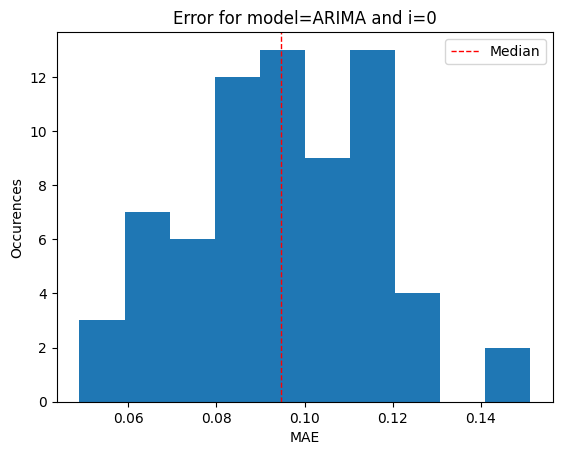

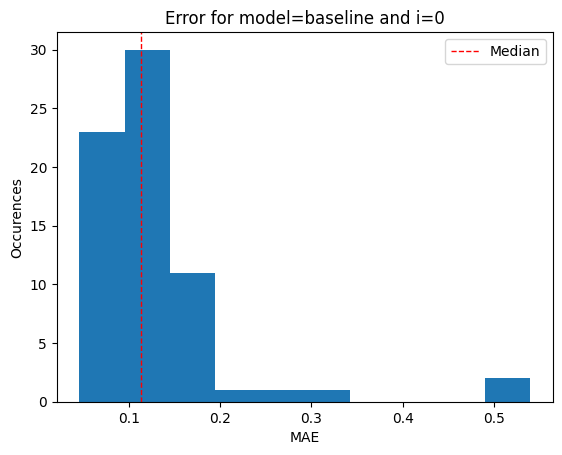

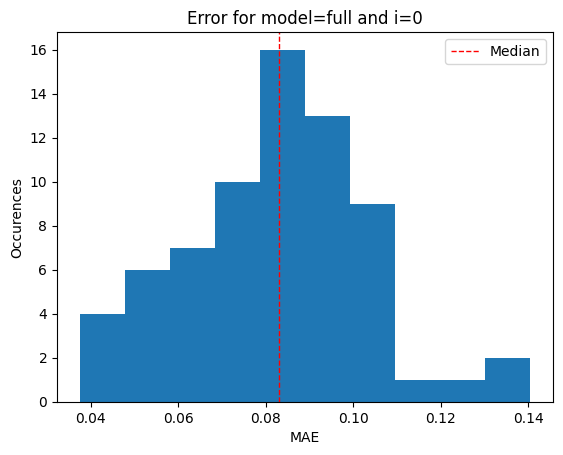

In [44]:
ARIMA_CatBoost_Errors.median_histogram(i=0)

In [49]:
ARIMA_CatBoost_Errors.wilcoxon_test(i=3, specific_model='full')

Specific model Comparison: full


,full0,full1,full2,full3
full0,NaN,-1,-1,-1
full1,-1,NaN,-1,-1
full2,-1,-1,NaN,-1
full3,-1,-1,-1,NaN


### Error plots

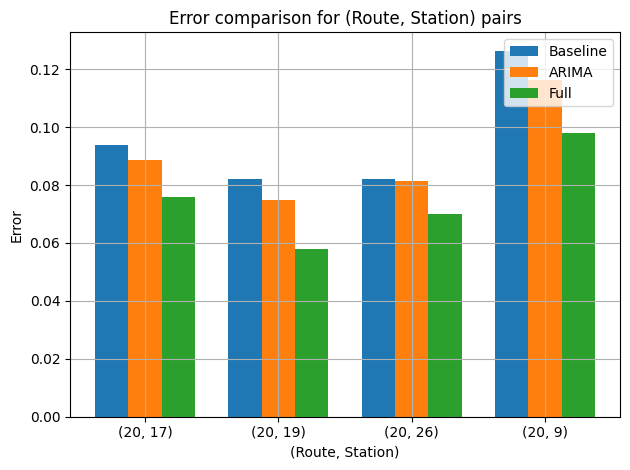

In [24]:
ARIMA_CatBoost_Errors.error_function()

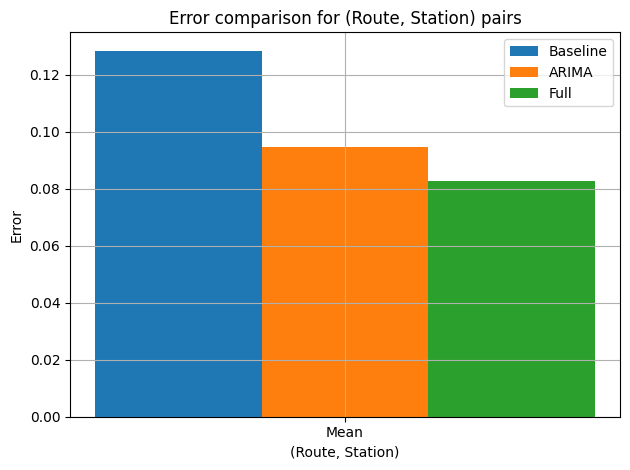

In [25]:
ARIMA_CatBoost_Errors.error_function(use_mean=True)

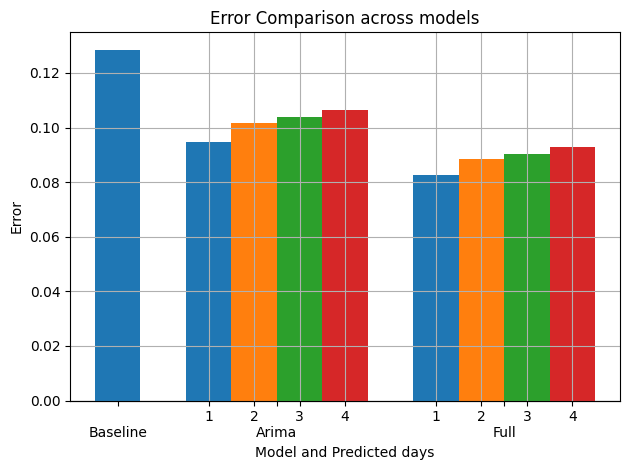

In [26]:
ARIMA_CatBoost_Errors.error_function(use_across_days=True)

In [33]:
def plot_columns(data_classes, column, column_arima=None):
    datasets = data_classes

    plt.figure(figsize=(10,7))
    bar_width = 0.15
    arima_found=False
    plt.bar([bar_width], (pd.DataFrame(datasets[0].data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean'))['Error_baseline0'], bar_width, label='Baseline')
    counter = 0
    for i, (dataset) in enumerate(datasets):
        dataset_df = (pd.DataFrame(dataset.data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')).sort_values(by='route_station')
        plt.bar([(counter+2) * bar_width], dataset_df[column].values, bar_width, label=dataset.model_name)
        counter += 1
        if column_arima in dataset_df.columns and not arima_found:
            plt.bar([(counter+2) * bar_width], dataset_df[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        plt.xticks([counter * bar_width-bar_width], dataset_df['route_station'])
    
    plt.legend()
    plt.title(f'Error full on {dataset.dataset_name} data')
    plt.grid()


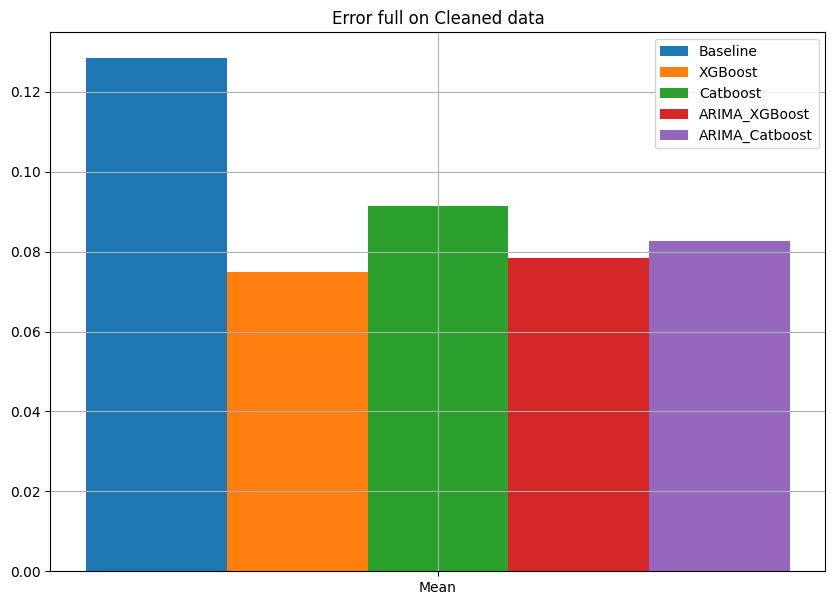

In [34]:
plot_columns([XGBoost_Errors, CatBoost_Errors, ARIMA_XGBoost_Errors, ARIMA_CatBoost_Errors], 'Error_full0', column_arima='Errors_ARIMA0')

In [28]:
from matplotlib.ticker import MaxNLocator
import ast

class CV_score(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('CV_score', dataset_name, model_names, specific_train_route, x)

    def CV_score_histplot(self, i=0, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        for _, row in data.iterrows():
            route_station = ast.literal_eval(row['route_station'])
            cv_scores_full = row[f'CV_score_full{i}']
            cv_scores_baseline = row[f'CV_score_baseline{i}']
            cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
            max_score = max(max(cv_scores_baseline), max(cv_scores_full))
            min_score = min(min(cv_scores_baseline), min(cv_scores_full))
            
            arima_check = not cv_scores_arima.empty

            if arima_check:
                max_score = max(max_score, max(cv_scores_arima))
                min_score = min(min_score, min(cv_scores_arima))
            
            num_bins = 15
            bins = np.linspace(min_score, max_score, num_bins)
            
            plt.hist(cv_scores_baseline, edgecolor="black", bins=bins, alpha=0.5, label='Baseline')
            
            if arima_check:
                plt.hist(cv_scores_arima, edgecolor="black", bins=bins, alpha=0.5, label='ARIMA')
            
            plt.hist(cv_scores_full, edgecolor="black", bins=bins, alpha=0.5, label='Full')

            plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
            plt.xlabel('MAE')
            plt.ylabel('Occurrences')
            plt.legend(loc='upper right')
            plt.grid()
            plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks in y-axis
            plt.show()
        
    def CV_score_lineplot(self, i=0, use_extracted=True, initial_start=30):
            data = self.data
            if use_extracted: data = self.data_route
            for _, row in data.iterrows():
                route_station = ast.literal_eval(row['route_station'])
                cv_scores_full = row[f'CV_score_full{i}']
                cv_scores_baseline = row[f'CV_score_baseline{i}']
                cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
                plt.plot(cv_scores_baseline[-initial_start:], label='Baseline')
                
                if not cv_scores_arima.empty:
                    plt.plot(cv_scores_arima[-initial_start:], label='ARIMA')

                plt.plot(cv_scores_full[-initial_start:], label='Full')
                
                plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
                plt.xlabel('Data points')
                plt.ylabel('MAE')
                plt.legend(loc='upper right')
                plt.grid()
                plt.show()
    def CV_score_function(self, use_hist=False, use_line=False, use_extracted=True, initial_start=30):
        if use_hist:
            self.CV_score_histplot(use_extracted = use_extracted)
        if use_line:
            self.CV_score_lineplot(use_extracted=use_extracted, initial_start=initial_start)
        

In [29]:
ARIMA_XGBoost_CV_scores = CV_score('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_XGBoost_CV_scores.data['CV_score_baseline0']

0     0      0.110041
1      0.098974
2      0.10791...
1     0      0.080149
1      0.027113
2      0.21690...
2     0      0.284765
1      0.126621
2      0.31355...
3     0      0.116715
1      0.088662
2      0.12262...
4     0      0.068299
1      0.068268
2      0.16276...
                            ...                        
64    0      0.020416
1      0.080407
2      0.03137...
65    0      0.045435
1      0.118415
2      0.02663...
66    0      0.046078
1      0.054057
2      0.11003...
67    0      0.092769
1      0.092727
2      0.01568...
68    0      0.039832
1      0.039814
2      0.08520...
Name: CV_score_baseline0, Length: 69, dtype: object

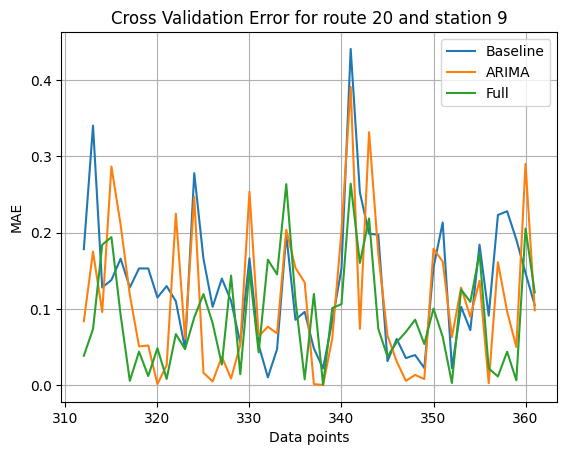

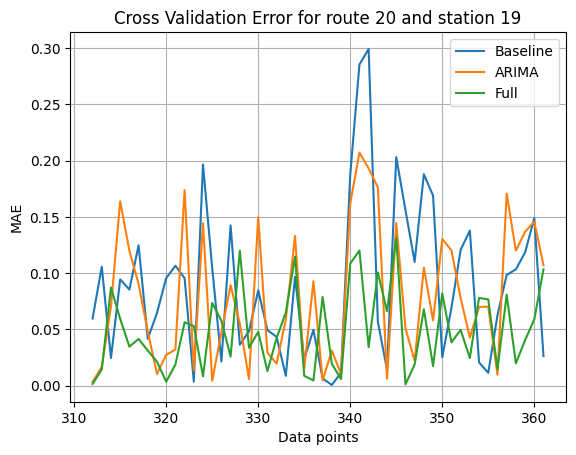

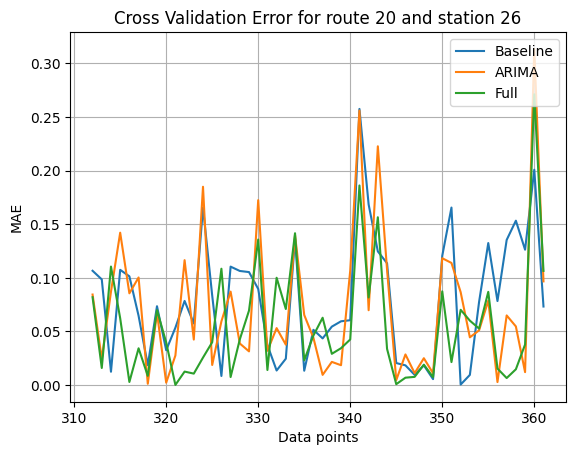

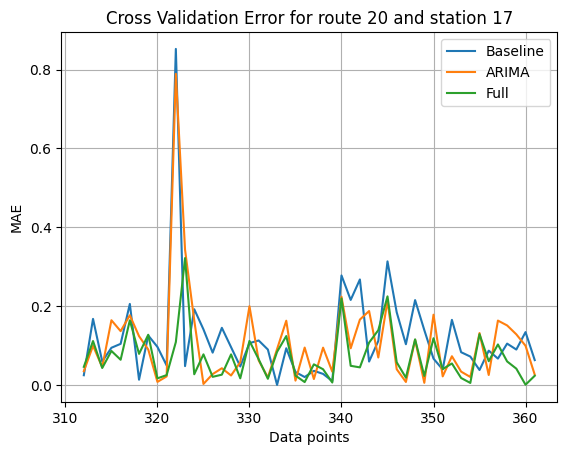

In [30]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_line=True, initial_start=50)

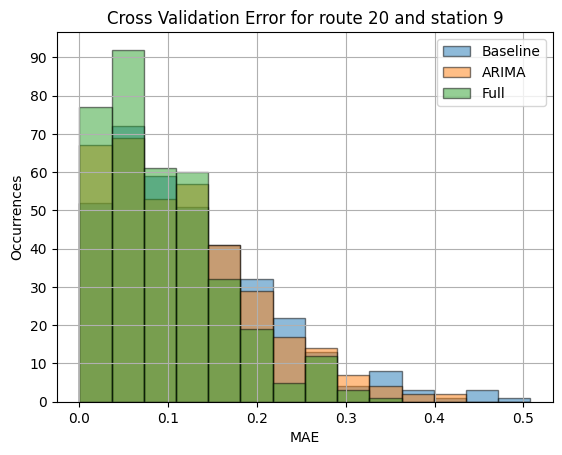

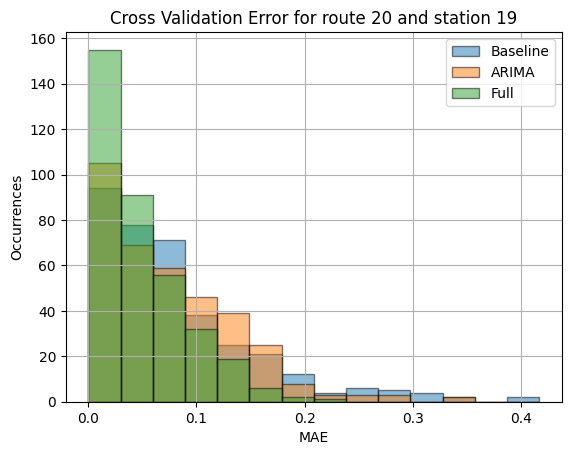

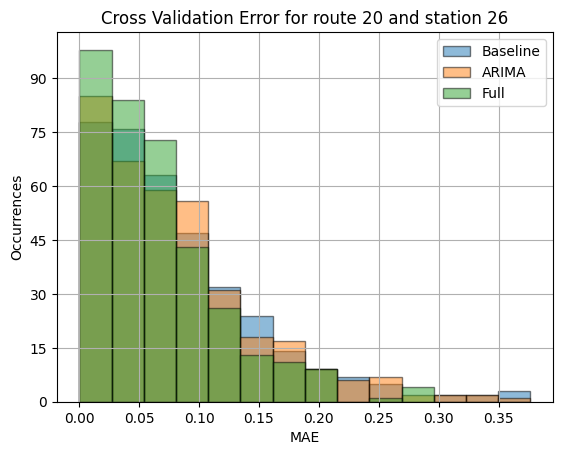

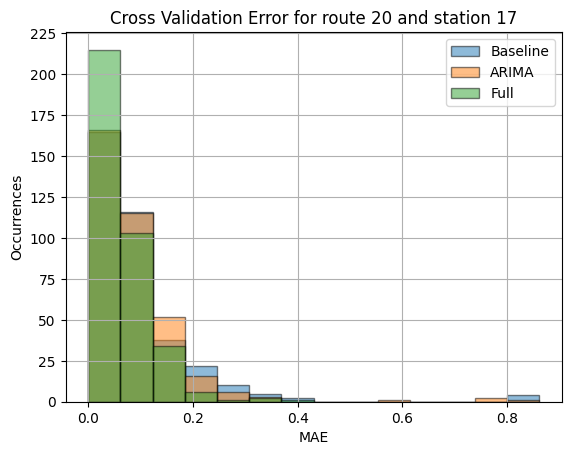

In [15]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_hist=True)

In [16]:
class Predictions(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Predictions', dataset_name, model_names, specific_train_route, x)

    def prediction_plot(self, i, initial_start, arima=False, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        initial_start = initial_start
        for row_no, row in data.iterrows():
            y_test = row[f'y_true{i}']
            # Extract corresponding predictions from predictions DataFrame
            predictions_full = row[f'Predictions_full{i}']
            # Dates: 
            x_dates = np.arange(initial_start)
            route_station = row['route_station']
            plt.plot(x_dates[-initial_start:], y_test[-initial_start:], color='#33a02c', label='Test Data')
            if arima:
                predictions_arima = row.get(f'Predictions_ARIMA{i}', [None])
                plt.plot(x_dates[-initial_start:], predictions_arima[-initial_start:], color='#1E77B4', marker='x', label='ARIMA Predictions')
            plt.plot(x_dates[-initial_start:], predictions_full[-initial_start:], color='#FD7E0E', marker='x', label='Full Predictions')
            plt.title(f'Route/station {route_station}: Predictions & True Value')
            plt.xlabel('Observations')
            plt.ylabel('Train punctuality')
            plt.xticks(x_dates[-initial_start::10], rotation=45)
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()
    def prediction_function(self, i, initial_start, arima, use_extracted):
        self.prediction_plot(i, initial_start, arima, use_extracted)

In [17]:
ARIMA_XGBoost_Predictions = Predictions('Cleaned', 'ARIMA_XGBoost', 20)
#ARIMA_XGBoost_Predictions.data

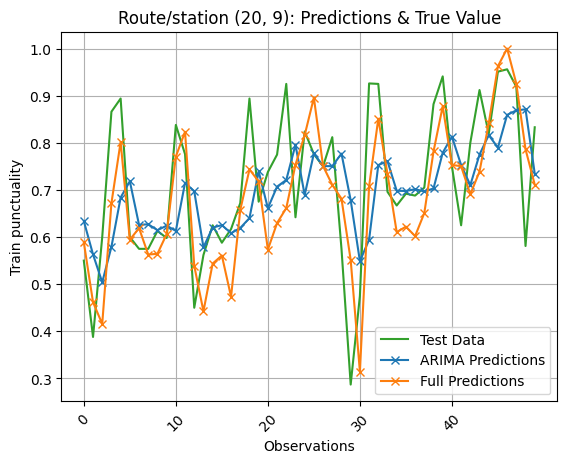

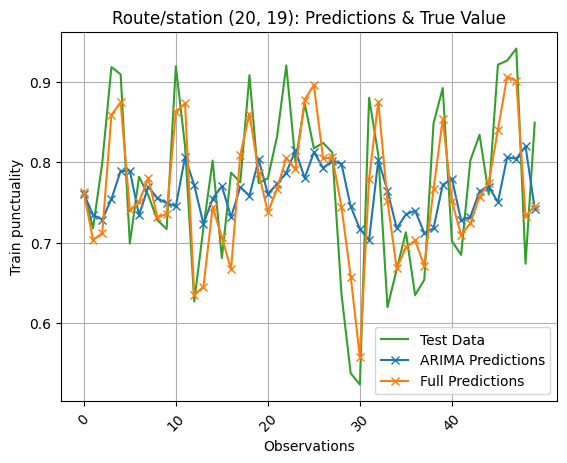

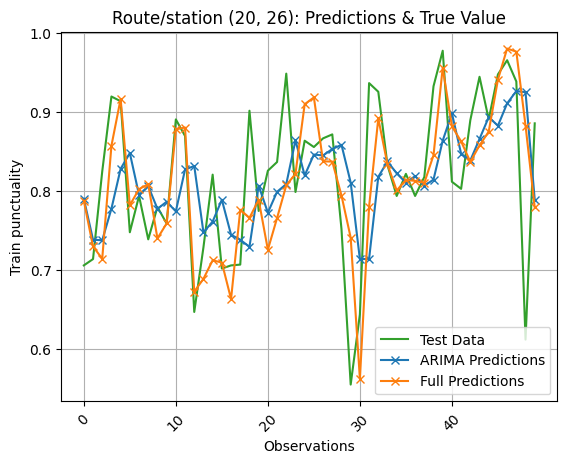

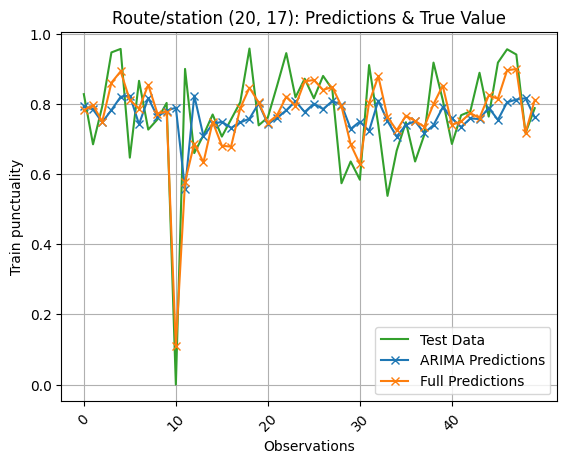

In [18]:
ARIMA_XGBoost_Predictions.prediction_function(i=0, initial_start=50, arima=True, use_extracted=True)